In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D

import cache_magic
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_PATH = './data/'
MODEL_PATH = './model'

ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'


IMG = DATA_PATH + 'img'

ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}

NUM_CLASSES = 26 

BATCH_SIZE = 4

EMPTY_CACHES = True

In [3]:
# Borrado de caches locales para evitar reevaluar todo el notebook
if(EMPTY_CACHES):
    %cache -r results_miniVGG
    %cache -r results_DenseNet121
    %cache -r results_DenseNet201
    %cache -r results_inceptionV3

Resetting cached values for results_miniVGG
Resetting cached values for results_DenseNet121
Resetting cached values for results_DenseNet201
Resetting cached values for results_inceptionV3


# Lectura y preprocesado de datos

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

# Lectura de atributos asociados a una imagen (lectura list_attr_img)
def read_attr_img_list():
    attr_dict = []
    with open(ATTR_IMG_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de lineas
        fp.readline() # Ignorar cabecera
        for line in fp:
            row = [int(i) for i in line.split()[1:]]
            attr_dict.append(row)
    return pd.DataFrame.from_records(attr_dict)


In [5]:
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
attr_img_list = read_attr_img_list()
attributes = list(column_to_attr_name.values())

In [6]:
def build_iterator_dataframe(partition):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    print(partition_attribute_filepath)
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [7]:
def read_image_list(file):
    file_path = ANNO_FINE_PATH + '/' + file + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            image_list = read_image_list(partition)
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [8]:
create_data_structure(False)

# Aumentación de datos

In [9]:
SEED = 1

def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)


def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train'),
        x_col="filename",
        y_col=attributes,
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val'),
        x_col="filename",
        y_col=attributes,
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator

def build_test_generator(img_size=150):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test'),
        x_col="filename",
        y_col=attributes,        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

## Búsqueda de parámetros óptimos

## Ejemplo de datos generados

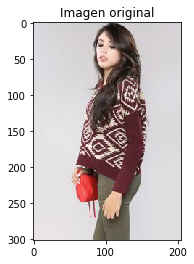

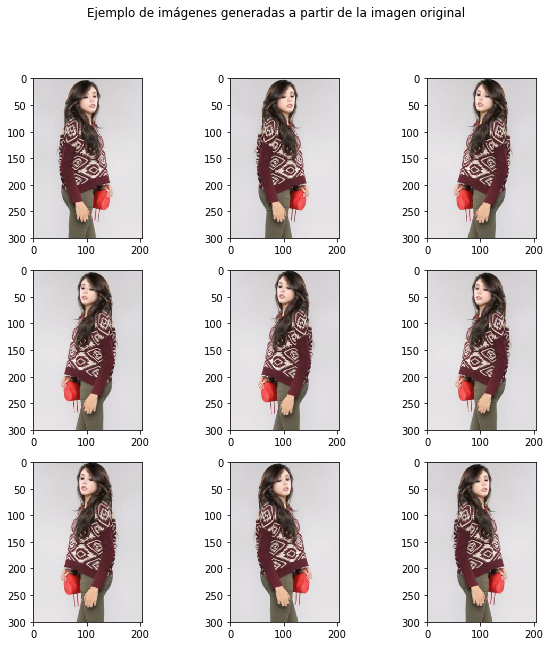

In [10]:
# Carga de una imagen aleatoria de la clase COVID
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

# Métricas

In [11]:
# VISUALIZACIÓN DE MÉTRICAS PARA COMPARAR MODELOS
# results = dict k -> (val_loss, val_acc)
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        ix = 0 if metric == 'val_loss' else 1
        plt.plot(v[ix])
        legend.append(k)
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

# Automatización

In [12]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [13]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model


def build_callbacks(model_name, model_id, store_model):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id), 
                                     monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.025, 
          zoom_range=0.025, 
          rotation_range=2.5, 
          fill_mode='nearest',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode)
    
    
    
    # FIT
    # Dependiendo de la complejidad del modelo, se hace fit una única vez, o dos veces para ajustar primero las últimas capas
    # y posteriormente el resto
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    
    return (h.history['val_loss'], h.history['val_top_k_categorical_accuracy'])

## Optimización de hiperparámetros

In [14]:
def build_baseline(input_shape, params=None):
    model = Sequential()

    # Añadir las capas indicadas
    model.add(Conv2D(32, kernel_size=3, strides=1, activation="relu", input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=3, strides=1, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation="sigmoid"))
    
    return model

### Tamaño de la imagen

### Parámetros de data augmentation

# Entrenamiento

In [15]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"

def build_baseline(input_shape, params=None):
    model = Sequential()

    # Añadir las capas indicadas
    model.add(Conv2D(32, kernel_size=3, strides=1, activation="relu", input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=3, strides=1, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation="sigmoid"))
    
    return model

def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling='avg',
        #classes=1000
        )
    # freeze_all_layers(base_model)
    
    x = base_model.output
    x = Dense(128, activation="relu")(x)
    x = Dense(26, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling='avg',
        #classes=1000
        )
    # freeze_all_layers(base_model)
    
    x = base_model.output
    x = Dense(128, activation="relu")(x)
    x = Dense(26, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling='avg',
        #classes=1000
        )
    # freeze_all_layers(base_model)
    
    x = base_model.output
    x = Dense(128, activation="relu")(x)
    x = Dense(26, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


In [16]:
model_id = 0
#%cache baseline_results = train('baseline', model_id)
#%cache -r resnet50_results
%cache resnet50_results = train('ResNet50', model_id)
#%cache inceptionV3_results = train('InceptionV3', model_id)
#%cache vgg16_results = train('VGG16', model_id)

Loading cached value for variable 'resnet50_results'. Time since caching: 0:54:52.999604


# Partición de Test

# Preentrenados

In [21]:
def top_k_recall(k, y_pred, y_true_df):
    correctly_annotated = [0] * 26
    ground_truth = [0] * 26
        
    # Itearción de etiquetas del conjunto de test
    for index, row in y_true_df.iterrows():
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1
        
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            if p in true_possitives[0]:
                correctly_annotated[p]+=1
        
    # print(num_correctly_annotated)
    # print(ground_truth)
    return sum(correctly_annotated)/sum(ground_truth)


def evaluate(model_path):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(model_path, compile = False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
    
    # Generator de datos de test
    test_generator = build_test_generator(img_size=224)
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    top_3_recall = top_k_recall(3, y_pred, y_true_df)
    top_5_recall = top_k_recall(5, y_pred, y_true_df)
    return (top_3_recall, top_5_recall)

In [22]:
evaluate('./model/ResNet50_0.h5')

./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 61s 488ms/step


(0.38825, 0.5844583333333333)

In [ ]:
pred[0]

In [ ]:
ind = np.argpartition(pred[0], -6)[-6:]
print(ind)

In [ ]:
pred[0].sort()
pred[0]